In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#pip install nrclex
from nrclex import NRCLex
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import datetime
import re
import nltk
from textblob import TextBlob
nltk.download('vader_lexicon')
nltk.download('punkt')  # For tokenization
nltk.download('averaged_perceptron_tagger')# Required for NRCLex


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sheebamoghal/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sheebamoghal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sheebamoghal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [12]:
df = pd.read_csv('/Users/sheebamoghal/Desktop/courses/DSAN 6000/fall-2024-project-team-35/data/csv/Merged_data.csv', delimiter=',', encoding='utf-8')

df.head(3)

,body,controversiality,created_utc,subreddit
0,I'd like to think I've dealt with cancer head ...,0,1719826058,CancerFamilySupport
1,thank you for pointing out how it’s misunderst...,0,1719799836,CrohnsDisease
2,It made me realise exactly how little I had. A...,0,1719847236,breastcancer


In [13]:
# checking for missing values
df.isna().sum()

body                0
controversiality    0
created_utc         0
subreddit           0
dtype: int64

In [14]:
#for i in df.columns:
#    print(df[i].unique())

print(df['subreddit'].unique())

print(df.dtypes)

# converting the time to datetime
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')  # Convert timestamp if necessary

['CancerFamilySupport' 'CrohnsDisease' 'breastcancer' 'thyroidcancer'
 'AskDocs' 'UlcerativeColitis' 'Autoimmune' 'BladderCancer'
 'doihavebreastcancer' 'Lymphedema' 'WomensHealth' 'ProstateCancer' 'cll'
 'Microbiome' 'predental' 'endometrialcancer' 'cancer' 'Hashimotos'
 'coloncancer' 'PreCervicalCancer' 'lymphoma' 'CancerCaregivers'
 'braincancer' 'publichealth' 'nursing' 'testicularcancer' 'lynchsyndrome'
 'HealthInsurance' 'Fuckcancer' 'BRCA' 'Cancersurvivors' 'Health'
 'leukemia' 'pancreaticcancer' 'skincancer' 'stomachcancer']
body                object
controversiality     int64
created_utc          int64
subreddit           object
dtype: object


In [15]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['body'] = df['body'].apply(preprocess_text)

df.head(2)

,body,controversiality,created_utc,subreddit
0,id like to think ive dealt with cancer head on...,0,2024-07-01 09:27:38,CancerFamilySupport
1,thank you for pointing out how its misundersto...,0,2024-07-01 02:10:36,CrohnsDisease


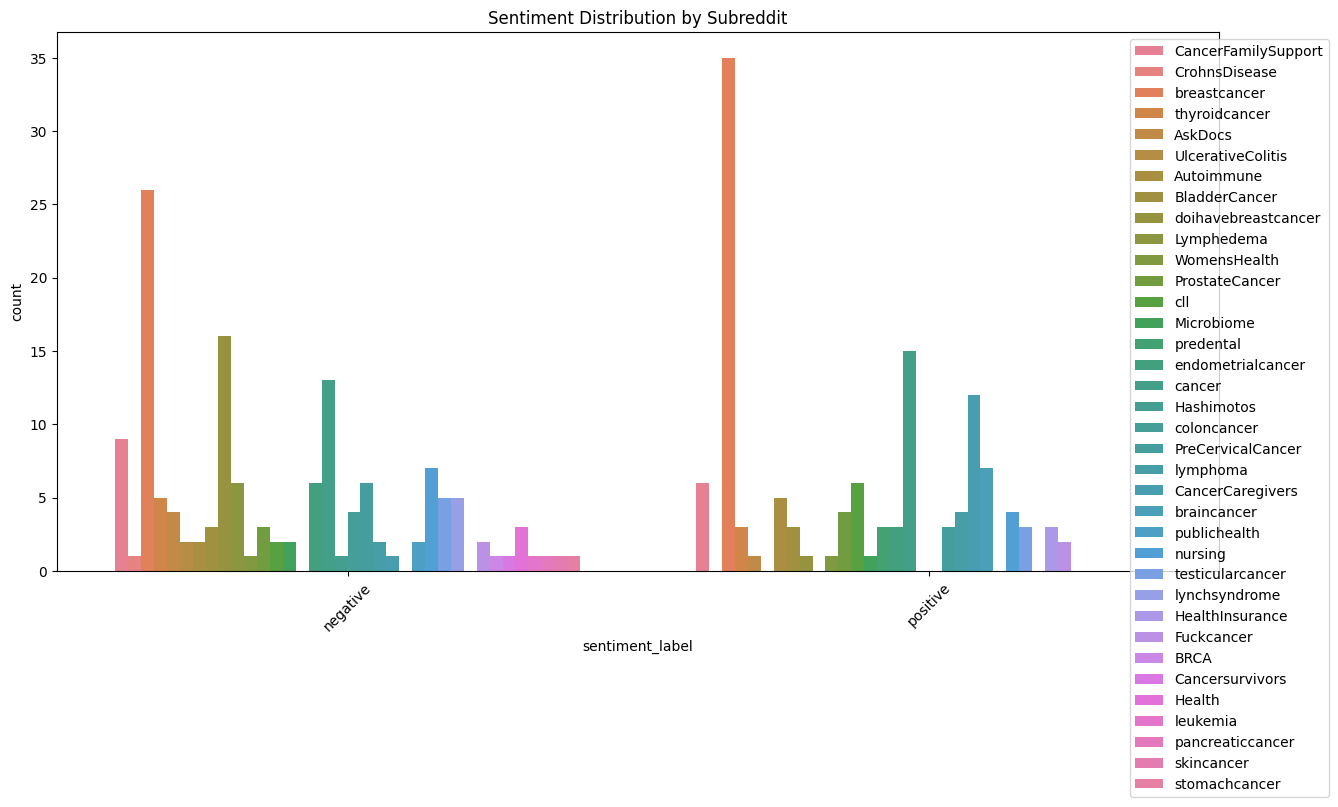

In [16]:
# Initialize Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# 1. Sentiment Distribution Across Subreddits
df['sentiment_score'] = df['body'].apply(lambda x: sid.polarity_scores(x)['compound'])
df['sentiment_label'] = df['sentiment_score'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

plt.figure(figsize=(15, 7))
sns.countplot(data=df, x='sentiment_label', hue='subreddit')
plt.title('Sentiment Distribution by Subreddit')
plt.xticks(rotation=45)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show()

In [17]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sheebamoghal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sheebamoghal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

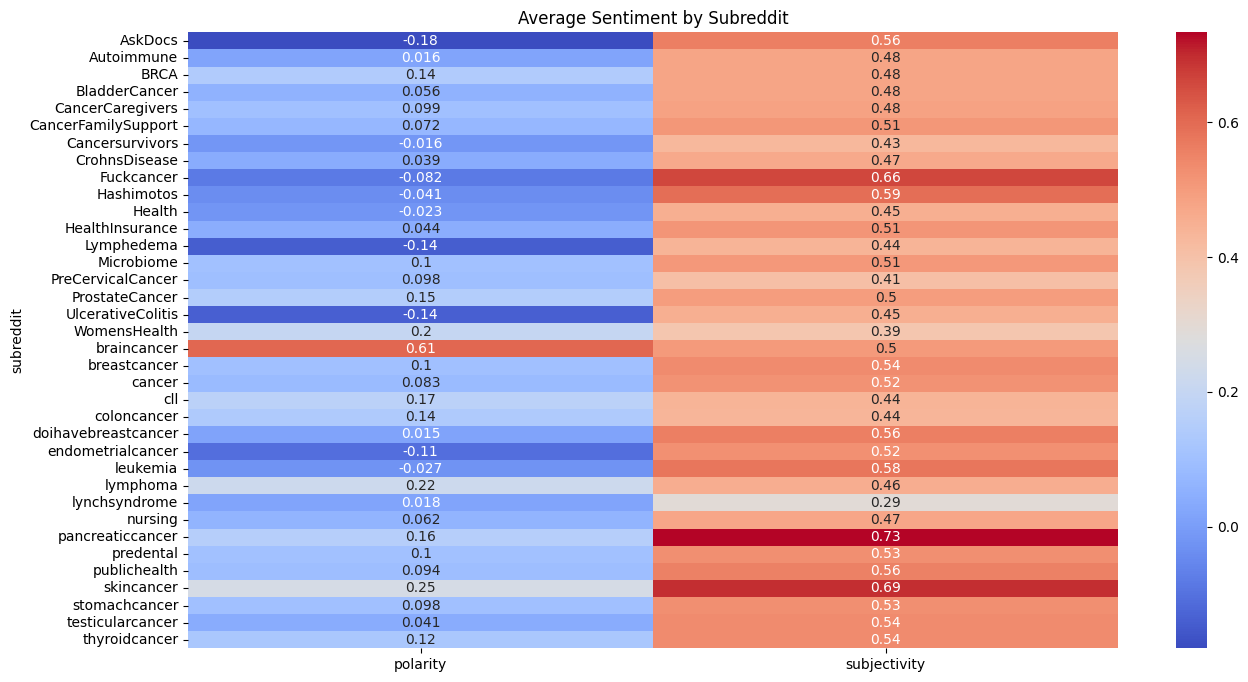

In [ ]:
#Using TextBlob for Sentiment Analysis as a Proxy for Emotions

def get_sentiment(text):
    blob = TextBlob(text)
    return {
        'polarity': blob.sentiment.polarity,       # -1 (negative) to 1 (positive)
        'subjectivity': blob.sentiment.subjectivity # 0 (objective) to 1 (subjective)
    }

sentiment_df = pd.DataFrame(df['body'].apply(get_sentiment).tolist())
sentiment_df['subreddit'] = df['subreddit']
sentiment_avg = sentiment_df.groupby('subreddit').mean()

plt.figure(figsize=(15, 8))
sns.heatmap(sentiment_avg, annot=True, cmap='coolwarm')
plt.title('Average Sentiment by Subreddit')
plt.show()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sheebamoghal/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


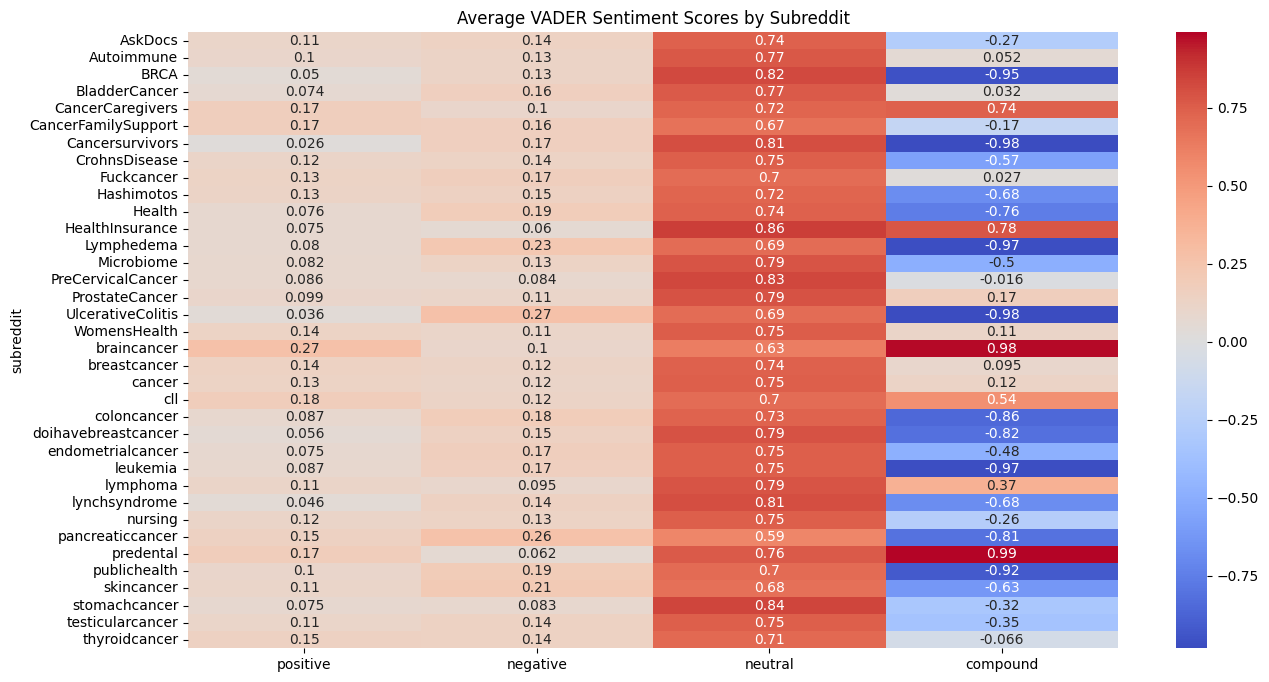

In [ ]:
# Using VADER for Emotion Scoring
# Initialize VADER
sid = SentimentIntensityAnalyzer()

def get_vader_scores(text):
    scores = sid.polarity_scores(text)
    return {
        'positive': scores['pos'],
        'negative': scores['neg'],
        'neutral': scores['neu'],
        'compound': scores['compound']
    }

vader_df = pd.DataFrame(df['body'].apply(get_vader_scores).tolist())
vader_df['subreddit'] = df['subreddit']
vader_avg = vader_df.groupby('subreddit').mean()

plt.figure(figsize=(15, 8))
sns.heatmap(vader_avg, annot=True, cmap='coolwarm')
plt.title('Average VADER Sentiment Scores by Subreddit')
plt.show()


In [ ]:
from transformers import pipeline

# Load a pretrained emotion classification model
emotion_classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

def get_emotions_transformers(text):
    emotion_scores = emotion_classifier(text)[0]  # Get the list of emotion scores for the text
    # Convert list of scores to a dictionary
    return {item['label']: item['score'] for item in emotion_scores}

# Apply to the DataFrame
emotion_df = pd.DataFrame(df['body'].apply(get_emotions_transformers).tolist())
emotion_df['subreddit'] = df['subreddit']
emotion_avg = emotion_df.groupby('subreddit').mean()

plt.figure(figsize=(15, 8))
sns.heatmap(emotion_avg, annot=True, cmap='coolwarm')
plt.title('Average Emotion Scores by Subreddit (Transformers Model)')
plt.show()


/Users/sheebamoghal/Desktop/courses/DSAN 6000/fall-2024-project-team-35/cancer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
